# Health Analytics Project 1: Diabetes Prediction

# S M Nazarat Hossain


The goal of this project is to build a model that identifies patients that have a diagnosis of Type 2 diabetes mellitus (T2DM). Diagnosis of T2DM is defined by a set of ICD9 codes: {'250', '250.0', 250.*0, and 250.*2} where 250.*0 means '250.00', '250.10', '250.20', ... '250.90' and 250.*2 means '250.02', '250.12', ... '250.92'. 

Note that ICD9 codes 250.*1 and 250.*3 are for Type I diabetes mellitus and are not to be classified. ICD9 codes are found in the table SyncDiagnosis.

 The datasetPracticeFusionDiabetes consist of 17 different files, 2 common files and 15 data set-specific files. They are in comma separated value (csv) format. Please refer to the data set dictionary for a description of the table elements and for a chart showing how the tables are connected.

 

Instructions:

There are a total of 9,948 patients in the data. The training set comprises 6,600 patients. The file training_SyncPatient.csv has an indicator column to show who has a diagnosis of Type 2 diabetes mellitus (T2DM). 
Use training data to do exploratory data analysis (distribution for diabetes based on male/female, smoking/non-smoking, age, and other data).
Build a predictive model to forecast diabetes given the details of a patient in the same format as training_SyncPatient.csv.
You will test the efficacy of your predictive model using test_SyncPatient.csv and output a file test_SyncPatientForecast.csv with a new column DMIndicatorForecast probability for each row.
The format of the input file test_SyncPatient.csv is:
PatientGuid
Gender
YearOfBirth
State
PracticeGuid
The format of the ouput file test_SyncPatientForecast.csv is:
PatientGuid
DMIndicatorForecast
Your model performance is going to be evaluated using the Brier score (https://en.wikipedia.org/wiki/Brier_scoreLinks to an external site.) that compares your T2DM probability with T2DM actual.



### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Loading Data

In [2]:
os.getcwd()

'C:\\Users\\nazar\\Desktop\\MScA\\Health_Analytics\\Assignment\\Assignment1'

In [3]:
SyncCondition = pd.read_csv("SyncCondition.csv")
SyncSmokingStatus = pd.read_csv("SyncSmokingStatus.csv")
test_SyncPatient = pd.read_csv("test_SyncPatient.csv")
training_SyncAllergy = pd.read_csv("training_SyncAllergy.csv")
training_SyncDiagnosis = pd.read_csv("training_SyncDiagnosis.csv")
training_SyncImmunization = pd.read_csv("training_SyncImmunization.csv")
training_SyncLabObservation = pd.read_csv("training_SyncLabObservation.csv")
training_SyncLabPanel = pd.read_csv("training_SyncLabPanel.csv")
training_SyncLabResult = pd.read_csv("training_SyncLabResult.csv")
training_SyncMedication = pd.read_csv("training_SyncMedication.csv")
training_SyncPatient = pd.read_csv("training_SyncPatient.csv")
training_SyncPatient_orig = pd.read_csv("training_SyncPatient_orig.csv")
training_SyncPatientCondition = pd.read_csv("training_SyncPatientCondition.csv")
training_SyncPatientSmokingStatus = pd.read_csv("training_SyncPatientSmokingStatus.csv")
training_SyncPrescription = pd.read_csv("training_SyncPrescription.csv")
training_SyncTranscript = pd.read_csv("training_SyncTranscript.csv")
training_SyncTranscriptAllergy = pd.read_csv("training_SyncTranscriptAllergy.csv")
training_SyncTranscriptDiagnosis = pd.read_csv("training_SyncTranscriptDiagnosis.csv")
training_SyncTranscriptMedication = pd.read_csv("training_SyncTranscriptMedication.csv")

# Exploratory Data Analysis (EDA)

In [4]:
table = pd.crosstab(training_SyncPatient['Gender'],training_SyncPatient['DMIndicator'])
table

DMIndicator,0.0,1.0
Gender,,
F,3119,618
M,2215,648


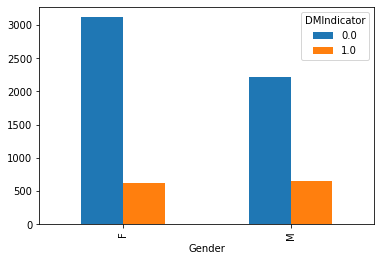

In [5]:
table.plot(kind='bar')

### Diabetes is higher among male than female

In [6]:
import datetime as dt
training_SyncPatient['This_Year'] = 2020
training_SyncPatient['age'] = training_SyncPatient['This_Year'] - training_SyncPatient['YearOfBirth']

In [7]:
bins = [0,30,35,39,45,49,55,59,65,69,75,79,85,89, np.inf]
names = ['<30', '30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']
training_SyncPatient['Age_Range'] = pd.cut(training_SyncPatient['age'], bins, labels=names)

In [8]:
table = pd.crosstab(training_SyncPatient['Age_Range'],training_SyncPatient['DMIndicator'])
table

DMIndicator,0.0,1.0
Age_Range,,
<30,229,2
30-34,248,3
35-39,272,7
40-44,490,24
45-49,348,32
50-54,602,77
55-59,420,81
60-64,647,174
65-69,389,120


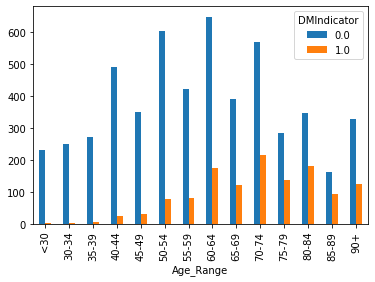

In [9]:
table.plot(kind='bar')

In [10]:
table = pd.crosstab([training_SyncPatient.Gender, training_SyncPatient.Age_Range],training_SyncPatient['DMIndicator'])
table

DMIndicator       0.0  1.0
Gender Age_Range          
F      <30        151    1
       30-34      170    3
       35-39      190    3
       40-44      311   11
       45-49      206   14
       50-54      342   33
       55-59      227   31
       60-64      362   88
       65-69      207   52
       70-74      311  100
       75-79      139   72
       80-84      201   90
       85-89       97   45
       90+        205   75
M      <30         78    1
       30-34       78    0
       35-39       82    4
       40-44      179   13
       45-49      142   18
       50-54      260   44
       55-59      193   50
       60-64      285   86
       65-69      182   68
       70-74      258  115
       75-79      146   65
       80-84      145   89
       85-89       65   47
       90+        122   48

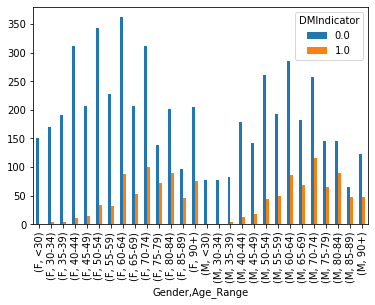

In [11]:
table.plot(kind='bar')

### Almost 50% of both male and female suffer diabetes after 70+ years.

In [12]:
training_SyncPatient = training_SyncPatient.dropna()

# Data Preparation

## Smoking Status

In [13]:
Smoking_Merged = training_SyncPatientSmokingStatus.merge(SyncSmokingStatus, how = 'left', on = 'SmokingStatusGuid')

In [14]:
Smoking_Merged.shape

(4940, 6)

In [15]:
Smoking_Merged.drop_duplicates(subset = 'PatientGuid', keep = 'last', inplace = True)

In [16]:
Smoking_Merged.head()

,PatientSmokingStatusGuid,PatientGuid,SmokingStatusGuid,EffectiveYear,Description,NISTcode
0,98D65810-96E1-4AF2-986E-001AB3FA8F07,418B3B82-D178-47D3-A6D4-B9F92A37D7DC,FCD437AA-0451-4D8A-9396-B6F19D8B25E8,2011,1-2 packs per day,1
1,AF76A721-2A12-4C30-A600-0020DC77DEE1,53183B47-C9F6-46D4-ACD1-D2B44B6263B0,DD01E545-D7AF-4F00-B248-9FD40010D81D,2011,Up to 1 pack per day,1
2,D2C7E57A-5CBC-4BB3-91BF-00249D55AFBA,4E01E2C2-387D-485E-8AFA-312AAB7B5026,1F3BFBBF-AB76-481B-B1E0-08A3689A54BC,2011,Not a current tobacco user,0
3,D230ED80-6318-4E48-A374-002928252CBA,B732CBF8-E855-4CA3-9548-7C0A1660CC52,5ABBAB35-836F-4F3E-8632-CE063828DA15,2012,0 cigarettes per day (non-smoker or less than ...,4
4,6ED5ABA8-7D47-49F8-8857-00321749C4D2,4AE52DF5-AB5B-4272-AF6C-789EFE0B58B3,5ABBAB35-836F-4F3E-8632-CE063828DA15,2011,0 cigarettes per day (non-smoker or less than ...,4


In [17]:
new_codes = [0]*Smoking_Merged.shape[0]
for i in range(Smoking_Merged.shape[0]):
    if Smoking_Merged['Description'].iloc[i] == '2 or more packs per day' or Smoking_Merged['Description'].iloc[i] == 'Up to 1 pack per day' or Smoking_Merged['Description'].iloc[i] == '1-2 packs per day':
        new_codes[i] = 2
    elif Smoking_Merged['Description'].iloc[i] == 'Current status unknown':
        new_codes[i] = 5
    elif Smoking_Merged['Description'].iloc[i] == 'Not a current tobacco user' or Smoking_Merged['Description'].iloc[i] == '0 cigarettes per day (previous smoker)':
        new_codes[i] = 0
    elif Smoking_Merged['Description'].iloc[i] == 'Few (1-3) cigarettes per day':
        new_codes[i] = 1
    elif Smoking_Merged['Description'].iloc[i] == '0 cigarettes per day (non-smoker or less than 100 in lifetime)':
        new_codes[i] = 3
    else:
        new_codes[i] = 4
Smoking_Merged['new_codes'] = new_codes

In [18]:
Smoking_Merged.drop_duplicates(subset = 'PatientGuid', keep = 'last', inplace = True)

In [19]:
Smoking_Merged.head()

,PatientSmokingStatusGuid,PatientGuid,SmokingStatusGuid,EffectiveYear,Description,NISTcode,new_codes
0,98D65810-96E1-4AF2-986E-001AB3FA8F07,418B3B82-D178-47D3-A6D4-B9F92A37D7DC,FCD437AA-0451-4D8A-9396-B6F19D8B25E8,2011,1-2 packs per day,1,2
1,AF76A721-2A12-4C30-A600-0020DC77DEE1,53183B47-C9F6-46D4-ACD1-D2B44B6263B0,DD01E545-D7AF-4F00-B248-9FD40010D81D,2011,Up to 1 pack per day,1,2
2,D2C7E57A-5CBC-4BB3-91BF-00249D55AFBA,4E01E2C2-387D-485E-8AFA-312AAB7B5026,1F3BFBBF-AB76-481B-B1E0-08A3689A54BC,2011,Not a current tobacco user,0,0
3,D230ED80-6318-4E48-A374-002928252CBA,B732CBF8-E855-4CA3-9548-7C0A1660CC52,5ABBAB35-836F-4F3E-8632-CE063828DA15,2012,0 cigarettes per day (non-smoker or less than ...,4,3
4,6ED5ABA8-7D47-49F8-8857-00321749C4D2,4AE52DF5-AB5B-4272-AF6C-789EFE0B58B3,5ABBAB35-836F-4F3E-8632-CE063828DA15,2011,0 cigarettes per day (non-smoker or less than ...,4,3


# Medication

In [20]:
training_SyncMedication = pd.read_csv("training_SyncMedication.csv")
training_SyncMedication.head()

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
0,0D6B339C-AB1F-4FF1-B231-000026C414C9,A7F1591C-9DB8-4F12-A0B8-15AC12C2B801,23490544301,Digoxin oral tablet,125 mcg (0.125 mg),NaN,DA833B28-CE04-4547-A94F-8A4E6C187A3B,1247EA46-61C3-4E91-ACF1-9C54D920ED05
1,72ADD073-CDA0-4F85-B6CB-00008B645E90,7A88D55F-22A9-4126-861D-92F0DA2ED701,143126730,Lisinopril oral tablet,10 mg,NaN,3ED5B90C-22A1-46EE-9CF5-027E684627D8,89049E64-8E9C-4863-8CF2-B6874235FA14
2,D35E505A-02F8-4EFD-A460-00042F85EF3E,F0B80C93-D371-44BE-B464-530C97FE6C02,456069801,Tessalon (benzonatate) oral capsule,200 mg,NaN,0B6C3285-1D8C-4C0F-9928-95EC226CB2FE,7511BCEC-9E46-4808-99A7-5B30778B6E84
3,FFB036B9-A636-48F2-967C-0005F8D78574,FF32CBDA-DDB1-4730-81C5-ACB0F321C2C5,60432060504,Promethazine VC Plain (phenylephrine-promethaz...,5 mg-6.25 mg/5 mL,NaN,DE2E15A5-5080-4141-A061-C81EC739C0A4,7CA1DC13-E602-4296-805F-A64DC8950C5A
4,AB095685-A703-4D81-8678-0009396BF105,1ECD93C8-75BD-4D3C-8D15-E2A3D0373090,247211730,Lexapro (escitalopram) oral tablet,10 mg,NaN,16B189A4-359C-41E1-BAA3-3E081EA24C41,92EBF1FE-3BE4-4367-83DD-C34F58B0B6C6


In [21]:
training_SyncMedication['Count'] = 1

In [22]:
training_SyncMedication = pd.crosstab(training_SyncMedication['PatientGuid'], training_SyncMedication['Count'])

In [23]:
training_SyncMedication.reset_index(level=0, inplace=True)

In [24]:
training_SyncMedication.columns = ['PatientGuid', 'Count_of_Medications']

In [25]:
training_SyncMedication.head()

,PatientGuid,Count_of_Medications
0,00023761-9D8D-445B-874C-2424CC7CF620,1
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,2
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,4
4,002667F4-B9A3-4DE2-875F-8034DD637865,1


In [26]:
training_SyncMedication.shape

(9846, 2)

# Transcript

In [27]:
training_SyncTranscript = pd.read_csv("training_SyncTranscript.csv")

In [28]:
training_SyncTranscript.isnull().sum()/training_SyncTranscript.shape[0]

TranscriptGuid        0.000000
PatientGuid           0.000000
VisitYear             0.000000
Height                0.541727
Weight                0.000000
BMI                   0.000000
SystolicBP            0.346872
DiastolicBP           0.346872
RespiratoryRate       0.609314
HeartRate             1.000000
Temperature           0.618151
PhysicianSpecialty    0.001381
UserGuid              0.000000
dtype: float64

In [29]:
training_SyncTranscript.drop_duplicates(subset = 'PatientGuid', keep = 'last', inplace = True)

In [30]:
training_SyncTranscript.shape

(9948, 13)

#### impute missing values

In [31]:
Transcript = training_SyncTranscript.merge(test_SyncPatient[{'PatientGuid','Gender','YearOfBirth'}], how = 'left', on = 'PatientGuid')

In [32]:
Transcript['Age'] = 2020 - Transcript['YearOfBirth']

In [33]:
Transcript[{'Age','YearOfBirth'}].head(10)

,YearOfBirth,Age
0,1972,48
1,1949,71
2,1945,75
3,1958,62
4,1968,52
5,1974,46
6,1980,40
7,1960,60
8,1954,66
9,1964,56


In [34]:
Transcript['Age'].min()

26

In [35]:
Transcript['Age'].max()

98

In [36]:
bins = [0,30,35,39,45,49,55,59,65,69,75,79,85,89, np.inf]
names = ['<30', '30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']
Transcript['Age_Range'] = pd.cut(Transcript['Age'], bins, labels=names)

In [37]:
Transcript_Male = Transcript[Transcript['Gender']=='M']
Transcript_Female = Transcript[Transcript['Gender']=='F']

In [38]:
BMI_Male = Transcript_Male[Transcript_Male['BMI'].notnull()].pivot_table(['BMI'],index = ['Age_Range'], aggfunc='mean')
BMI_Male_dict = BMI_Male.T.to_dict('records')

BMI_Female = Transcript_Female[Transcript_Female['BMI'].notnull()].pivot_table(['BMI'],index = ['Age_Range'], aggfunc='mean')
BMI_Female_dict = BMI_Male.T.to_dict('records')

Weight_Male = Transcript_Male[Transcript_Male['Weight'].notnull()].pivot_table(['Weight'],index = ['Age_Range'], aggfunc='mean')
Weight_Male_dict = BMI_Male.T.to_dict('records')

Weight_Female = Transcript_Female[Transcript_Female['Weight'].notnull()].pivot_table(['Weight'],index = ['Age_Range'], aggfunc='mean')
Weight_Female_dict = BMI_Male.T.to_dict('records')

SystolicBP_Male = Transcript_Male[Transcript_Male['SystolicBP'].notnull()].pivot_table(['SystolicBP'],index = ['Age_Range'], aggfunc='mean')
SystolicBP_Male_dict = BMI_Male.T.to_dict('records')

DiastolicBP_Male = Transcript_Male[Transcript_Male['DiastolicBP'].notnull()].pivot_table(['DiastolicBP'],index = ['Age_Range'], aggfunc='mean')
DiastolicBP_Male_dict = BMI_Male.T.to_dict('records')

SystolicBP_Female = Transcript_Female[Transcript_Female['SystolicBP'].notnull()].pivot_table(['SystolicBP'],index = ['Age_Range'], aggfunc='mean')
SystolicBP_Female_dict = BMI_Male.T.to_dict('records')

DiastolicBP_Female = Transcript_Female[Transcript_Female['DiastolicBP'].notnull()].pivot_table(['DiastolicBP'],index = ['Age_Range'], aggfunc='mean')
DiastolicBP_Female_dict = BMI_Male.T.to_dict('records')

In [39]:
new_bmi = [0]*Transcript.shape[0]
new_weight = [0]*Transcript.shape[0]
new_Diastolic = [0]*Transcript.shape[0]
new_Systolic = [0]*Transcript.shape[0]

In [40]:
for i in range(Transcript.shape[0]):
    if (pd.isnull(Transcript['Weight'].iloc[i])) or (Transcript['Weight'].iloc[i] == 0):
        if Transcript['Gender'].iloc[i] == 'M':
            new_weight[i] = Weight_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_weight[i] = Weight_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_weight[i] = Transcript['Weight'].iloc[i]

In [41]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['BMI'].iloc[i]) or Transcript['BMI'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_bmi[i] = BMI_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_bmi[i] = BMI_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_bmi[i] = Transcript['BMI'].iloc[i]

In [42]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['DiastolicBP'].iloc[i]) or Transcript['DiastolicBP'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_Diastolic[i] = DiastolicBP_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_Diastolic[i] = DiastolicBP_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_Diastolic[i] = Transcript['DiastolicBP'].iloc[i]

In [43]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['SystolicBP'].iloc[i]) or Transcript['SystolicBP'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_Systolic[i] = SystolicBP_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_Systolic[i] = SystolicBP_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_Systolic[i] = Transcript['SystolicBP'].iloc[i]

In [44]:
Transcript['New_BMI'] = new_bmi
Transcript['New_Weight'] = new_weight
Transcript['New_DiastolicBP'] = new_Diastolic
Transcript['New_SystolicBP'] = new_Systolic

In [45]:
Transcript.columns

Index(['TranscriptGuid', 'PatientGuid', 'VisitYear', 'Height', 'Weight', 'BMI',
       'SystolicBP', 'DiastolicBP', 'RespiratoryRate', 'HeartRate',
       'Temperature', 'PhysicianSpecialty', 'UserGuid', 'YearOfBirth',
       'Gender', 'Age', 'Age_Range', 'New_BMI', 'New_Weight',
       'New_DiastolicBP', 'New_SystolicBP'],
      dtype='object')

In [46]:
average_height_male = Transcript[(Transcript['Height'].notnull()) & (Transcript['Gender']=='M')]['Height'].mean()
average_height_female = Transcript[(Transcript['Height'].notnull()) & (Transcript['Gender']=='F')]['Height'].mean()

In [47]:
print("average height of males is...",average_height_male)
print("average height of females is...",average_height_female)

average height of males is... 69.03608808933006
average height of females is... 63.47138578512397


In [48]:
TM = Transcript[Transcript['Gender']=='M'].copy()
TF = Transcript[Transcript['Gender']=='F'].copy()

In [49]:
TM['Height'].fillna(value=average_height_male, inplace = True)
TF['Height'].fillna(value=average_height_female, inplace = True)

In [50]:
Transcript_Final = pd.concat([TM,TF])

In [51]:
Transcript_Final.isnull().sum()

TranscriptGuid           0
PatientGuid              0
VisitYear                0
Height                   0
Weight                   0
BMI                      0
SystolicBP            2646
DiastolicBP           2646
RespiratoryRate       5608
HeartRate             9948
Temperature           5437
PhysicianSpecialty      10
UserGuid                 0
YearOfBirth              0
Gender                   0
Age                      0
Age_Range                0
New_BMI                  0
New_Weight               0
New_DiastolicBP          0
New_SystolicBP           0
dtype: int64

In [52]:
Transcript_Final.drop(['BMI','Weight','DiastolicBP','SystolicBP','Age','Gender','YearOfBirth'], axis = 1, inplace = True)

In [53]:
Transcript_Final.rename(columns = {'New_BMI':'BMI','New_Weight':'Weight','New_DiastolicBP':'DiastolicBP','New_SystolicBP':'SystolicBP'}, inplace = True)

In [54]:
train_test_SyncPatient = test_SyncPatient.merge(training_SyncPatient[{'PatientGuid','DMIndicator'}], how = 'left', on = 'PatientGuid')

In [55]:
Patient = train_test_SyncPatient

In [56]:
Patient.shape

(9948, 6)

In [57]:
Patient_Medication = Patient.merge(training_SyncMedication, how = 'left', on  = 'PatientGuid')

In [58]:
Patient_Medication.shape

(9948, 7)

In [59]:
Patient_Medication.head()

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid,DMIndicator,Count_of_Medications
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,M,1929,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737,0.0,5.0
1,C6746626-6783-4650-A58F-00065649139A,F,1985,TX,E7101967-2FF1-4B0F-8129-B0B429D1D15C,0.0,2.0
2,E05C6E8F-779F-4594-A388-000C635AE4D3,F,1984,NJ,FC01A799-1CAF-464F-A86F-8A666AB86F32,0.0,4.0
3,EAEBD216-F847-4355-87B2-000D942E08F0,M,1959,OH,EEBC95EF-79BE-4542-892E-98D3166BAB20,0.0,15.0
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,F,1990,FL,677BA32E-B4C4-48F2-86E4-08C42B135401,0.0,1.0


In [60]:
Patient_Medication_Smoking = Patient_Medication.merge(Smoking_Merged[{'PatientGuid', 'EffectiveYear','new_codes'}], how = 'left', on  = 'PatientGuid')

In [61]:
Patient_Medication_Smoking.shape

(9948, 9)

In [62]:
Patient_Medication_Smoking.head()

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid,DMIndicator,Count_of_Medications,new_codes,EffectiveYear
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,M,1929,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737,0.0,5.0,NaN,NaN
1,C6746626-6783-4650-A58F-00065649139A,F,1985,TX,E7101967-2FF1-4B0F-8129-B0B429D1D15C,0.0,2.0,3.0,2012.0
2,E05C6E8F-779F-4594-A388-000C635AE4D3,F,1984,NJ,FC01A799-1CAF-464F-A86F-8A666AB86F32,0.0,4.0,NaN,NaN
3,EAEBD216-F847-4355-87B2-000D942E08F0,M,1959,OH,EEBC95EF-79BE-4542-892E-98D3166BAB20,0.0,15.0,2.0,2011.0
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,F,1990,FL,677BA32E-B4C4-48F2-86E4-08C42B135401,0.0,1.0,NaN,NaN


In [63]:
Patient_Medication_Smoking_Transcript = Patient_Medication_Smoking.merge(Transcript_Final[{'PatientGuid', 'Height','BMI','Weight', 'DiastolicBP','SystolicBP'}], how = 'left', on  = 'PatientGuid')

In [64]:
Patient_Medication_Smoking_Transcript.shape

(9948, 14)

In [65]:
Patient_Medication_Smoking_Transcript.isnull().sum()

PatientGuid                0
Gender                     0
YearOfBirth                0
State                      0
PracticeGuid               0
DMIndicator             3348
Count_of_Medications     102
new_codes               5521
EffectiveYear           5521
BMI                        0
DiastolicBP                0
Height                     0
Weight                     0
SystolicBP                 0
dtype: int64

In [66]:
Patient_Medication_Smoking_Transcript['new_codes'].fillna(value=5, inplace = True)

In [67]:
Patient_Medication_Smoking_Transcript['Count_of_Medications'].median()

3.0

In [68]:
Patient_Medication_Smoking_Transcript['Count_of_Medications'].fillna(value = 3, inplace = True)

In [69]:
def region(State):
    if State == 'CT' or State == 'ME' or State == 'MA' or State == 'NH' or State == 'RI' or State == 'VT' or State == 'NJ' or State == 'NY' or State == 'PA':
        return 0
    elif State == 'IL' or State == 'IN' or State == 'MI' or State == 'OH' or State == 'WI' or State == 'IA' or State == 'KS' or State == 'MN' or State == 'MO' or State == 'NE' or State == 'ND' or State == 'SD':
        return 1
    elif State == 'AZ' or State == 'CO' or State == 'ID' or State == 'MT' or State == 'NV' or State == 'NM' or State == 'UT' or State == 'WY' or State == 'AK' or State == 'CA' or State == 'HI' or State == 'OR' or State == 'WA':
        return 2
    elif State == 'DE' or State == 'FL' or State == 'GA' or State == 'MD' or State == 'NC' or State == 'SC' or State == 'VA' or State == 'DC' or State == 'WV' or State == 'AL' or State == 'KY' or State == 'MS' or State == 'TN' or State == 'AR' or State == 'OK' or State == 'TX' or State == 'LA':
        return 3
    else:
        return 4

In [70]:
Region = [region(State) for State in Patient_Medication_Smoking_Transcript.State]

In [71]:
Patient_Medication_Smoking_Transcript['Region'] = Region

In [72]:
Patient_Medication_Smoking_Transcript[{'Region','State'}].head()

,State,Region
0,SD,1
1,TX,3
2,NJ,0
3,OH,1
4,FL,3


In [73]:
Patient_Medication_Smoking_Transcript.columns

Index(['PatientGuid', 'Gender', 'YearOfBirth', 'State', 'PracticeGuid',
       'DMIndicator', 'Count_of_Medications', 'new_codes', 'EffectiveYear',
       'BMI', 'DiastolicBP', 'Height', 'Weight', 'SystolicBP', 'Region'],
      dtype='object')

In [74]:
Patient_Medication_Smoking_Transcript['Age'] = 2020-Patient_Medication_Smoking_Transcript['YearOfBirth']

In [75]:
bins = [0, 49, 57, np.inf]
names = [0,1,2]
Patient_Medication_Smoking_Transcript['AgeBucket'] = pd.cut(Patient_Medication_Smoking_Transcript['Age'], bins, labels=names)

In [76]:
Patient_Medication_Smoking_Transcript.columns

Index(['PatientGuid', 'Gender', 'YearOfBirth', 'State', 'PracticeGuid',
       'DMIndicator', 'Count_of_Medications', 'new_codes', 'EffectiveYear',
       'BMI', 'DiastolicBP', 'Height', 'Weight', 'SystolicBP', 'Region', 'Age',
       'AgeBucket'],
      dtype='object')

In [77]:
from sklearn.preprocessing import LabelEncoder
class_label = LabelEncoder()
Patient_Medication_Smoking_Transcript['Gender_New'] = class_label.fit_transform(Patient_Medication_Smoking_Transcript['Gender'])

In [78]:
def add_bmi_range(x): 
    bmi = x[0]
    
    if (bmi<18.5):
        return 0
    elif (18.5<=bmi<25):
        return 1
    elif (25<=bmi<30):
        return 2
    elif (30<=bmi):
        return 3
    else:
        return 'Measurement Error'
    

Patient_Medication_Smoking_Transcript['BMI_Category'] = Patient_Medication_Smoking_Transcript[['BMI']].apply(add_bmi_range, axis=1)

In [79]:
Patient_Medication_Smoking_Transcript[{'BMI_Category'}].head(20)

,BMI_Category
0,0
1,0
2,3
3,3
4,3
5,3
6,2
7,0
8,2
9,0


In [80]:
Patient_Medication_Smoking_Transcript.drop(['EffectiveYear','State','Age','YearOfBirth','Gender', 'BMI', 'PracticeGuid' ], axis = 1, inplace = True)

In [81]:
Patient_Medication_Smoking_Transcript.shape

(9948, 12)

In [82]:
Patient_Medication_Smoking_Transcript.isnull().sum()

PatientGuid                0
DMIndicator             3348
Count_of_Medications       0
new_codes                  0
DiastolicBP                0
Height                     0
Weight                     0
SystolicBP                 0
Region                     0
AgeBucket                  0
Gender_New                 0
BMI_Category               0
dtype: int64

# Models 

### Train Test Split

In [83]:
Patient_Medication_Smoking_Transcript.columns

Index(['PatientGuid', 'DMIndicator', 'Count_of_Medications', 'new_codes',
       'DiastolicBP', 'Height', 'Weight', 'SystolicBP', 'Region', 'AgeBucket',
       'Gender_New', 'BMI_Category'],
      dtype='object')

In [84]:
train = Patient_Medication_Smoking_Transcript[Patient_Medication_Smoking_Transcript['DMIndicator'].notnull()]
test = Patient_Medication_Smoking_Transcript[Patient_Medication_Smoking_Transcript['DMIndicator'].isnull()]

In [85]:
train.shape

(6600, 12)

In [86]:
test.shape

(3348, 12)

In [87]:
# Separate input features (X) and target variable (y)

x = train.drop(['DMIndicator', 'PatientGuid'], axis = 1)
x_cols = x.columns
y = train.DMIndicator

In [88]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [90]:
y_test.shape

(1650,)

## Logistic Regression

In [91]:
# Train model
clf_logreg = LogisticRegression()

In [92]:
#fit model
clf_logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
#create predictions based on model
y_pred = clf_logreg.predict(x_test)

#### Classification Report

In [94]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90      1334
         1.0       0.67      0.04      0.07       316

    accuracy                           0.81      1650
   macro avg       0.74      0.52      0.48      1650
weighted avg       0.79      0.81      0.74      1650



#### Probablity

In [95]:
#create predictions based on model
y_pred = clf_logreg.predict_proba(x_test)

#### Brier Score of Logistic Regression MOdel

In [96]:
from sklearn.metrics import brier_score_loss

y_pred = y_pred[:,1]

brier_score_loss(y_test, y_pred)

0.1406284614828142

## Random Forest

In [97]:
# Train model
clf_rf = RandomForestClassifier(n_estimators=100, random_state=1)

In [98]:
#fit model
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [99]:
#create predictions based on model
y_pred_clf_rf = clf_rf.predict(x_test)

In [100]:
print(metrics.classification_report(y_test, y_pred_clf_rf))

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      1334
         1.0       0.39      0.14      0.21       316

    accuracy                           0.79      1650
   macro avg       0.61      0.54      0.54      1650
weighted avg       0.74      0.79      0.75      1650



In [101]:
#create the confusion matrices
confusion_matrix_clf_rf = metrics.confusion_matrix(y_test, y_pred_clf_rf)
confusion_matrix_clf_rf

array([[1266,   68],
       [ 272,   44]], dtype=int64)

In [102]:
#create the probabilities
clf_rf_probs = clf_rf.predict_proba(x_test)
probs_clf_rf = clf_rf_probs[:, 1]

### Brier Score of Random Forest

In [103]:
brier_score_loss(y_test, probs_clf_rf)

0.15165792437352113

# Support Vector Machine

In [104]:
# Train model
clf_svc = SVC(kernel='linear', probability=True, random_state=1)

In [105]:
#fit model
clf_svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [106]:
#create predictions based on model
y_pred_clf_svc = clf_rf.predict(x_test)

In [107]:
print(metrics.classification_report(y_test, y_pred_clf_svc))

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      1334
         1.0       0.39      0.14      0.21       316

    accuracy                           0.79      1650
   macro avg       0.61      0.54      0.54      1650
weighted avg       0.74      0.79      0.75      1650



In [108]:
#create the probabilities
clf_svc_probs = clf_svc.predict_proba(x_test)
probs_clf_svc = clf_svc_probs[:, 1]

#### Brier Score of Support Vector Machine

In [109]:
brier_score_loss(y_test, probs_clf_svc)

0.15443405797937143

# Neural Networks

In [150]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier

# Train model
#clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf_NN = MLPClassifier()

# Fir model
clf_NN.fit(x_train, y_train)

#create predictions based on model
y_pred_clf_NN = clf_NN.predict(x_test)

C:\Users\nazar\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [151]:
print(metrics.classification_report(y_test, y_pred_clf_NN))

              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      1334
         1.0       0.49      0.13      0.21       316

    accuracy                           0.81      1650
   macro avg       0.66      0.55      0.55      1650
weighted avg       0.76      0.81      0.76      1650



In [152]:
#create the probabilities
clf_NN_probs = clf_NN.predict_proba(x_test)
probs_clf_NN = clf_NN_probs[:, 1]

#### Brier Score of Neural Networks

In [153]:
brier_score_loss(y_test, probs_clf_NN)

0.13914560972093062

In [124]:
# Train model
MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Considering the Brier Score of four models: Logistic Regression 0.14, Radom Forest 0.15, Support Vector Machine 0.15, and Neural Networks 0.13),  Neural Networks perform the best as it has the lowest Brier Score. 

## Test Data Set 

In [114]:
PatientGuid = list(test.PatientGuid)

In [115]:
# Separate input features (X) and target variable (y)
x = test.drop(['DMIndicator', 'PatientGuid'], axis = 1)
x_cols = x.columns
y = test.DMIndicator
# y

### DMIndicator is not available for "Test data" set. So, only prediction probablity of diabetes is calculated.

In [116]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [117]:
y_pred = clf_logreg.predict_proba(x)

In [118]:
y_pred = y_pred[:,1]

In [119]:
Final = pd.DataFrame(y_pred)
Final.columns =['Probablity_diabetes'] 

In [120]:
Final['PatientGuid'] = PatientGuid

In [121]:
Final.head()

,Probablity_diabetes,PatientGuid
0,0.036361,027AC271-0852-4DDD-99C2-A74FE50066E0
1,0.230718,C5D4C6FA-A2B3-4CCD-A8D5-A760127CE47D
2,0.363296,1F4D1486-7632-4576-AC92-A760680D1DC9
3,0.217090,0F6AD971-F133-4BD7-B508-A76788D9C46C
4,0.171866,1E23496C-7AAF-4A91-AAF4-A769BD439E67


In [122]:
Final.to_csv("Project1_Nazarat.csv", index = False)